In [1]:
from pydlr import kernel, dlr
from triqs.gf import *
from h5 import HDFArchive
import numpy as np
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

import matplotlib.pyplot as plt
plt.style.use('publish')

from dimer import *
from common import *

Starting serial run at: 2023-02-12 10:54:24.896686


**Confirmation** Here I confirm that the norm is computed correctly.

In [2]:
sigma_moments = sigma_high_frequency_moments(dm, hdiag, gf_struct, h_int)
sig_infty, sigma_1 = sigma_moments['up'][0], sigma_moments['up'][1]

In [3]:
d = dlr(lamb=30)
freq = d.get_matsubara_frequencies(beta)
G0_tau = make_gf_from_fourier(G0_iw)
tau_i = np.array([x.real for x in G0_tau.mesh])
iw_i  = np.array([complex(x) for x in Sigma_iw_ref.mesh])

In [4]:
g_iaa = G_tau_ref['up'].data
g0_iaa = G0_tau['up'].data
g_xaa = d.lstsq_dlr_from_tau(tau_i, g_iaa, beta)
g0_xaa = d.lstsq_dlr_from_tau(tau_i, g0_iaa, beta)

In [5]:
gk_iwaa = d.matsubara_from_dlr(g_xaa, beta)
g0k_iwaa = d.matsubara_from_dlr(g0_xaa, beta)

In [6]:
σk_iwaa = np.linalg.inv(g0k_iwaa[:,...])-np.linalg.inv(gk_iwaa[:,...])

In [7]:
rk_iwaa = gk_iwaa - g0k_iwaa[:,...]@σk_iwaa[:,...]@gk_iwaa[:,...]  - g0k_iwaa

In [8]:
r_xaa = d.lstsq_dlr_from_matsubara(freq, rk_iwaa, beta)

In [9]:
Mkl = np.zeros((len(d), len(d)))
for iwk, wk in enumerate(d.dlrrf):
    for iwl, wl in enumerate(d.dlrrf):
        K0wk, Kbwk = kernel(np.array([0,1]), np.array([wk])).flatten()
        K0wl, Kbwl = kernel(np.array([0, 1]), np.array([wl])).flatten()
        if np.fabs(wk+wl) < 1e-13:
            Mkl[iwk,iwl] = K0wk*K0wl
        else:
            Mkl[iwk, iwl] = (1/(beta*(wk+wl)))*(K0wk*K0wl - Kbwk*Kbwl)

In [10]:
y = np.einsum('nmk,kl,lnm->nm', r_xaa.T, Mkl, r_xaa).flatten()
np.linalg.norm(y)

3.636843318108796e-15

This is the expected result!

In [11]:
class Symmetrizer:

    def __init__(self, nx, no):
        self.N = (no*(no-1))//2
        self.nx, self.no = nx, no
        self.diag_idxs = np.arange(self.no)
        self.triu_idxs = np.triu_indices(no, k=1)
        self.tril_idxs = np.tril_indices(no, k=-1)
    
    def get_x_d(self, g_xaa):
        x_d = g_xaa[:, self.diag_idxs, self.diag_idxs].flatten()
        return x_d

    def set_x_d(self, g_xaa, x_d):
        g_xaa[:, self.diag_idxs, self.diag_idxs] = x_d.reshape((self.nx, self.no))
        return g_xaa

    def get_x_u(self, g_xaa):
        x_u = g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]].flatten()
        return x_u

    def set_x_u(self, g_xaa, x_u):
        g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]] = x_u.reshape((self.nx, self.N))
        g_xaa[:, self.tril_idxs[0], self.tril_idxs[1]] = g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]].conj()
        #g_xaa += np.transpose(g_xaa, axes=(0,2,1)).conj()
        return g_xaa

    def get_diag_indices(self): return self.diag_idxs
    def get_triu_indices(self): return self.triu_idxs

In [25]:
def constrained_lstsq_dlr_from_tau(d,         # dlr class
                                   tau_i,     # tau mesh
                                   beta,      # inverse temperature
                                   g_iaa,     # G data
                                   g0_iaa,    # G0 data
                                   sigma_moments, # high-freq moments of Σ
                                   method = {'norm': 'iw',  # norm -> { 'tau', 'iw'}
                                             'optim': 'dlr', # optim -> { 'dlr', 'sigma'}
                                            }, # driver for different settings
                                   ftol=1e-9, 
                                   symmetrizer=None,
                                   verbose = True):
    
    
    
    
    
    nx = len(d)
    ni, no, _ = g_iaa.shape
    shape_xaa = (nx, no, no)
    N = (no*(no-1))//2

    dtype = complex
    nX = nx * (no + 2*N)
    
    # precompute Mkl
    def compute_mkl(d):
        Mkl = np.zeros((len(d), len(d)), dtype=np.float128)
        for iwk, wk in enumerate(d.dlrrf):
            for iwl, wl in enumerate(d.dlrrf):
                K0wk, Kbwk = kernel(np.array([0,1]), np.array([wk])).flatten()
                K0wl, Kbwl = kernel(np.array([0,1]), np.array([wl])).flatten()
                if np.fabs(wk+wl) < 1e-13:
                    Mkl[iwk,iwl] = K0wk*K0wl
                else:
                    Mkl[iwk, iwl] = (1/(beta*(wk+wl)))*(K0wk*K0wl - Kbwk*Kbwl)
        return Mkl
    
    # fold and unfold complex numbers
    
    def merge_re_im(x):
        x_d, x_u = x[:nx*no], x[nx*no:]
        re, im = np.split(x_u, 2)
        x_u = re + 1.j * im
        return x_d, x_u

    def split_re_im(x_d, x_u):
        return np.concatenate((
            np.array(x_d.real, dtype=float),
            np.array(x_u.real, dtype=float),
            np.array(x_u.imag, dtype=float)))
                                   
    # Greens function <-> vector conversion

    sym = symmetrizer if symmetrizer is not None else Symmetrizer(nx, no)
    
    def g_from_x(x):
        x_d, x_u = merge_re_im(x)
        g_xaa = np.zeros((nx, no, no), dtype=dtype)
        sym.set_x_u(g_xaa, x_u)
        sym.set_x_d(g_xaa, x_d)
        return g_xaa
                        
    def x_from_g(g_xaa):
        x_d = sym.get_x_d(g_xaa)
        x_u = sym.get_x_u(g_xaa)
        x = split_re_im(x_d, x_u)
        return x
    
    
    # constraint
    sig_infty, sigma_1 = sigma_moments[0], sigma_moments[1]
        
    def mat_vec(mat):
        v_d = sym.get_x_d(mat[None, ...]).real
        v_u = sym.get_x_u(mat[None, ...])
        v = split_re_im(v_d, v_u)
        return v
        
    def constraint_func(x):
    
        if method['optim'] == 'sigma':
            sig = g_from_x(x)
            sig_xaa = d.lstsq_dlr_from_matsubara(freq, sig-sig_infty, beta)
            mat = -sig_xaa.sum(axis=0)
        else:
            sig_xaa = g_from_x(x)
            mat = -sig_xaa.sum(axis=0)
            
        vec = mat_vec(mat)
        return vec
    
    bound = mat_vec(sigma_1)
    
    constraints = (NonlinearConstraint(constraint_func,
                                           bound, bound))


    # target function
    def dyson_difference(x):
        
        if method['optim'] == 'sigma':
            sigk_iwaa = g_from_x(x)
        else:
            sig_xaa = g_from_x(x)
            sigk_iwaa = d.matsubara_from_dlr(sig_xaa, beta)+sig_infty
            
        #  G - G0 - G0*Σ*G = 0 done on the DLR nodes
        rk_iwaa = gk_iwaa - g0k_iwaa - g0k_iwaa[:,...]@sigk_iwaa[:,...]@gk_iwaa[:,...]
        
        if method['norm'] == 'tau':
            # compute DLR of rk_iwaa
            r_xaa = d.lstsq_dlr_from_matsubara(freq, rk_iwaa, beta)
            # ||R||^2 = r^T @ M @ r
            return np.einsum('nmk,kl,lnm->nm', r_xaa.T, Mkl, r_xaa).flatten()
        else:
            return rk_iwaa.flatten()
        
    def target_function(x):
        y = dyson_difference(x)
        return np.linalg.norm(y)
        
    
    if method['norm'] == 'tau':
        # compute Mkl
        Mkl = compute_mkl(d)
        
    freq = d.get_matsubara_frequencies(beta)
    
    # dlr fit to G and G0
    g_xaa = d.lstsq_dlr_from_tau(tau_i, g_iaa, beta)
    g0_xaa = d.lstsq_dlr_from_tau(tau_i, g0_iaa, beta)
    
    if verbose:
        g=d.eval_dlr_tau(g_xaa, tau_i, beta)
        g0=d.eval_dlr_tau(g0_xaa,tau_i,  beta)
        print('initial DLR fits to G(τ) and G0(τ)')
        print(f'|G(τ) - Gdlr(τ)| = {np.max(np.abs(g-g_iaa)):.6e}')
        print(f'|G0(τ) - G0dlr(τ)| = {np.max(np.abs(g0-g0_iaa)):.6e}')
    
    # compute and obtain initial Σ
    gk_iwaa = d.matsubara_from_dlr(g_xaa, beta)
    g0k_iwaa = d.matsubara_from_dlr(g0_xaa, beta)
    
    sigk_iwaa = np.linalg.inv(g0k_iwaa[:,...])-np.linalg.inv(gk_iwaa[:,...])
    
    if method['optim'] == 'sigma':
        # optimize Σ(iν)
        x_init = x_from_g(sigk_iwaa)
    else:
        # optimize σ -> Σ(iν) = Aσ + Σoo
        x_init = x_from_g(d.lstsq_dlr_from_matsubara(freq, sigk_iwaa-sig_infty, beta))
        

    # minimize
    sol = minimize(target_function, 
                   x_init,
        method='SLSQP', 
        constraints=constraints,
        options=dict(ftol=ftol, maxiter=1000, disp=True),
        )
    print(sol.success, sol.message)
    
    if method['optim'] == 'sigma':
        sigk_iwaa = g_from_x(sol.x)
        sig_xaa = d.lstsq_dlr_from_matsubara(freq, sigk_iwaa-sig_infty, beta)
    else:
        sig_xaa = g_from_x(sol.x)
        
    print(f'Σ1 constraint diff: {np.max(np.abs(-sig_xaa.sum(axis=0)-sigma_1)):.4e}')

    return sig_xaa, sol

## Hubbard Atom

In [105]:
beta = 10
U    = 2

iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_iw=100)

G0_iw = Gf(mesh=iw_mesh, target_shape=[1,1])
G0_iw << inverse(iOmega_n + U/2)

G0_tau = make_gf_from_fourier(G0_iw)

G_iw  = Gf(mesh=iw_mesh, target_shape=[1,1])
G_iw  << inverse(2*(iOmega_n + U/2)) + inverse(2*(iOmega_n - U/2))

G_tau = make_gf_from_fourier(G_iw)

G_tau_qmc = G_tau.copy()

tol = 1e-8
G_tau_qmc.data[:] += np.random.normal(scale=tol, size=G_tau_qmc.data.shape)
G_iw_qmc = make_gf_from_fourier(G_tau_qmc)

Sigma_iw = G_iw.copy()
Sigma_iw << U/2 + 0.25*U*U*inverse(iOmega_n)

Greens Function  with mesh Matsubara Freq Mesh of size 200, Domain: Matsubara domain with beta = 10, statistic = Fermion, positive_only : 0 and target_shape (1, 1): 

In [106]:
Sigma_iw_num = inverse(G0_iw)-inverse(G_iw)
Sigma_iw_qmc = inverse(G0_iw)-inverse(G_iw_qmc)

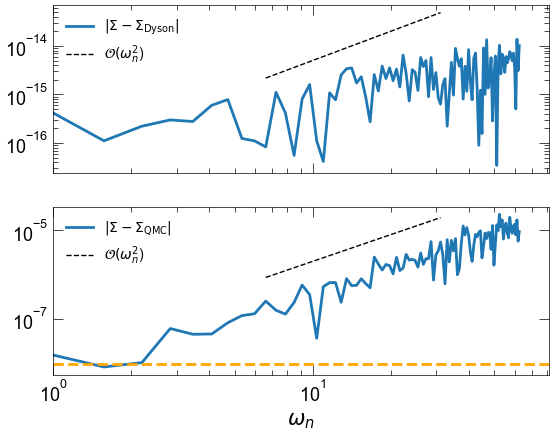

In [111]:
fig, ax = plt.subplots(2,1,sharex=True)
iw = np.array([complex(x) for x in G_iw.mesh])
ax[0].loglog(iw.imag, np.abs(Sigma_iw_num.data[:,0,0]-Sigma_iw.data[:,0,0]),label='$|\Sigma-\Sigma_{\mathrm{Dyson}}|$')
ax[0].loglog(iw.imag[110:150], (5e-17*iw.imag[110:150]**2), 'k--', lw=1, label=r'$\mathcal{O}(\omega_{n}^{2}$)')
ax[-1].set_xlim(1,)
ax[0].legend()
ax[1].loglog(iw.imag, np.abs(Sigma_iw_qmc.data[:,0,0]-Sigma_iw.data[:,0,0]),label='$|\Sigma-\Sigma_{\mathrm{QMC}}|$')
ax[1].loglog(iw.imag[110:150], (2*tol*iw.imag[110:150]**2), 'k--', lw=1, label=r'$\mathcal{O}(\omega_{n}^{2}$)')
ax[1].axhline(tol, ls='--', color='orange')
ax[1].legend()
ax[1].set_xlabel(r'$\omega_{n}$')
plt.show()

In [112]:
d = dlr(lamb=30, eps=1e-9)
tau_i = np.array([float(x) for x in G_tau_qmc.mesh])
sigma_moments=np.array([U/2, 0.25*U*U])

In [113]:
methods = [{'norm': 'tau', 'optim': 'dlr'},
           {'norm': 'iw', 'optim': 'dlr'},
           {'norm': 'iw', 'optim': 'sigma'},
           {'norm': 'tau', 'optim': 'sigma'}
          ]

Sigma_iw_fit = [None]*len(methods)
for im, method in enumerate(methods):
    print('Method: Optimize = {}, Norm = {}'.format(method['optim'], method['norm']))
    sig_xaa, sol = constrained_lstsq_dlr_from_tau(d,
                                   tau_i,    
                                   beta, 
                                   G_tau.data,
                                   G0_tau.data, 
                                   sigma_moments.reshape(-1,1,1),
                                   method = method, 
                                   ftol=1e-9)
    Sigma_iw_fit[im] = Sigma_iw.copy()
    Sigma_iw_fit[im].data[:] = d.eval_dlr_freq(sig_xaa, iw, beta) +sigma_moments[0]
    print('\n')

Method: Optimize = dlr, Norm = tau
initial DLR fits to G(τ) and G0(τ)
|G(τ) - Gdlr(τ)| = 6.019986e-09
|G0(τ) - G0dlr(τ)| = 8.929744e-09
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.7574277237717839326e-14
            Iterations: 1
            Function evaluations: 20
            Gradient evaluations: 1
True Optimization terminated successfully
Σ1 constraint diff: 4.4409e-16


Method: Optimize = dlr, Norm = iw
initial DLR fits to G(τ) and G0(τ)
|G(τ) - Gdlr(τ)| = 6.019986e-09
|G0(τ) - G0dlr(τ)| = 8.929744e-09
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2002713228787958e-08
            Iterations: 41
            Function evaluations: 925
            Gradient evaluations: 41
True Optimization terminated successfully
Σ1 constraint diff: 2.2204e-16


Method: Optimize = sigma, Norm = iw
initial DLR fits to G(τ) and G0(τ)
|G(τ) - Gdlr(τ)| = 6.019986e-09
|G0(τ) - G0dlr(τ)| = 8.929744e-09
Optimization

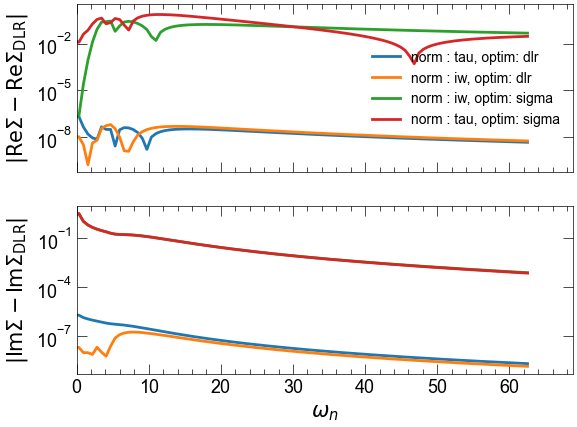

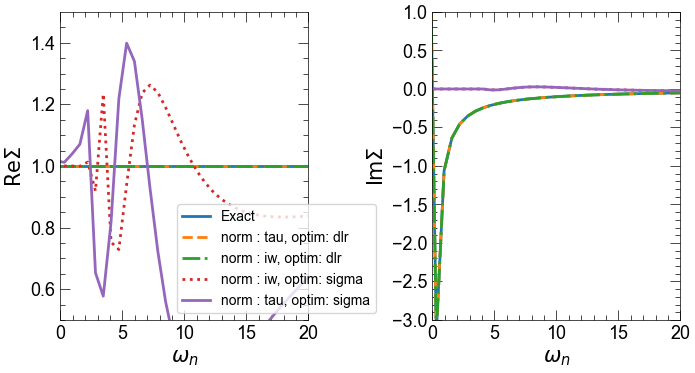

In [114]:
fig, ax = plt.subplots(2,1,sharex=True)
iw = np.array([complex(x) for x in G_iw.mesh])
for method, sigma in zip(methods, Sigma_iw_fit):
    label='norm : {}, optim: {}'.format(method['norm'], method['optim'])
    ax[0].semilogy(iw.imag, np.abs(sigma.data[:,0,0].real-Sigma_iw.data[:,0,0].real),label=label)
    ax[1].semilogy(iw.imag, np.abs(sigma.data[:,0,0].imag-Sigma_iw.data[:,0,0].imag))

ax[0].legend()
ax[0].set_xlim(0,)
ax[0].set_ylabel('$|\mathrm{Re}\Sigma-\mathrm{Re}\Sigma_{\mathrm{DLR}}|$')
ax[1].set_ylabel('$|\mathrm{Im}\Sigma-\mathrm{Im}\Sigma_{\mathrm{DLR}}|$')
ax[1].set_xlim(0,)
ax[1].set_xlabel(r'$\omega_{n}$')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(8,4))
iw = np.array([complex(x) for x in G_iw.mesh])
ax[0].plot(iw.imag, Sigma_iw.data[:,0,0].real,label='Exact')
ax[1].plot(iw.imag, Sigma_iw.data[:,0,0].imag)

for method, sigma,ls in zip(methods, Sigma_iw_fit, ['--', '-.', ':', '-']):
    label='norm : {}, optim: {}'.format(method['norm'], method['optim'])
    ax[0].plot(iw.imag, sigma.data[:,0,0].real,ls=ls,label=label)
    ax[1].plot(iw.imag, sigma.data[:,0,0].imag, ls=ls)

ax[0].legend(frameon=True, loc='lower right',bbox_to_anchor=(1.3, 0.))
ax[0].set_xlim(0,20); ax[0].set_ylim(1/2, 3/2)
ax[0].set_ylabel('$\mathrm{Re}\Sigma$')
ax[1].set_ylabel('$\mathrm{Im}\Sigma$')
ax[1].set_xlim(0,20); ax[1].set_ylim(-3, 1)
ax[0].set_xlabel(r'$\omega_{n}$'); ax[1].set_xlabel(r'$\omega_{n}$')
plt.subplots_adjust(wspace=0.5)
plt.show()

In [80]:
method = 
sig_xaa, sol = constrained_lstsq_dlr_from_tau(d,
                                   tau_i,    
                                   beta, 
                                   G_tau_qmc.data,
                                   G0_tau.data, 
                                   sigma_moments.reshape(-1,1,1),
                                   method = method, 
                                   ftol=1e-9)
Sigma_iw_fit = Sigma_iw.copy()
Sigma_iw_fit.data[:] = d.eval_dlr_freq(sig_xaa, iw, beta) +sigma_moments[0]

initial DLR fits to G(τ) and G0(τ)
|G(τ) - Gdlr(τ)| = 2.720550e-04
|G0(τ) - G0dlr(τ)| = 1.207528e-07
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.87894859892388e-05
            Iterations: 51
            Function evaluations: 894
            Gradient evaluations: 51
True Optimization terminated successfully
Σ1 constraint diff: 1.1369e-13


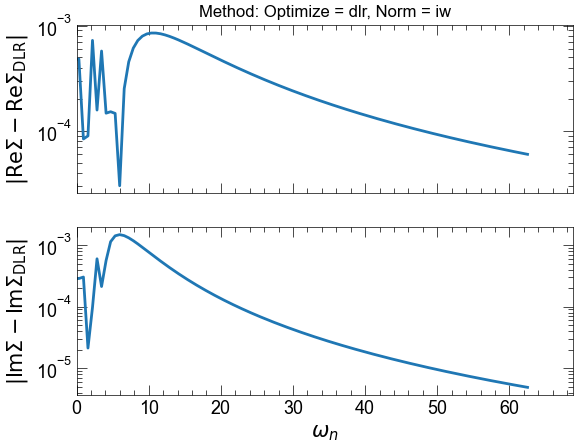

In [81]:
fig, ax = plt.subplots(2,1,sharex=True)
iw = np.array([complex(x) for x in G_iw.mesh])
ax[0].set_title('Method: Optimize = {}, Norm = {}'.format(method['optim'], method['norm']))
ax[0].semilogy(iw.imag, np.abs(Sigma_iw_fit.data[:,0,0].real-Sigma_iw.data[:,0,0].real))
ax[0].set_ylabel('$|\mathrm{Re}\Sigma-\mathrm{Re}\Sigma_{\mathrm{DLR}}|$')
ax[0].set_xlim(0,)
ax[1].semilogy(iw.imag, np.abs(Sigma_iw_fit.data[:,0,0].imag-Sigma_iw.data[:,0,0].imag))
ax[1].set_ylabel('$|\mathrm{Im}\Sigma-\mathrm{Im}\Sigma_{\mathrm{DLR}}|$')
ax[1].set_xlim(0,)
ax[1].set_xlabel(r'$\omega_{n}$')
plt.show()

In [82]:
method = {'norm': 'iw', 'optim': 'sigma'}
sig_xaa, sol = constrained_lstsq_dlr_from_tau(d,
                                   tau_i,    
                                   beta, 
                                   G_tau_qmc.data,
                                   G0_tau.data, 
                                   sigma_moments.reshape(-1,1,1),
                                   method = method, 
                                   ftol=1e-9)
Sigma_iw_fit = Sigma_iw.copy()
Sigma_iw_fit.data[:] = d.eval_dlr_freq(sig_xaa, iw, beta) +sigma_moments[0]

initial DLR fits to G(τ) and G0(τ)
|G(τ) - Gdlr(τ)| = 2.720550e-04
|G0(τ) - G0dlr(τ)| = 1.207528e-07
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3663413734955154
            Iterations: 522
            Function evaluations: 9451
            Gradient evaluations: 522
True Optimization terminated successfully
Σ1 constraint diff: 1.5659e+00


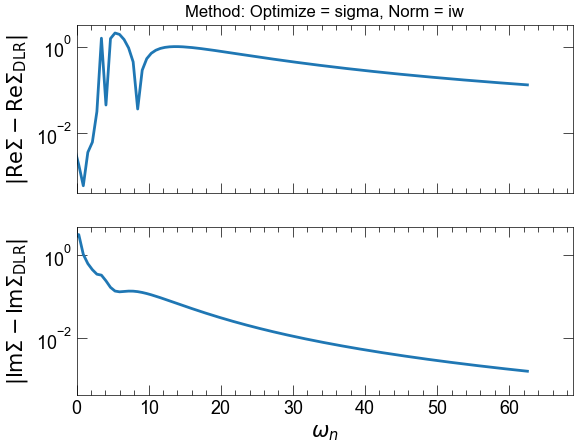

In [83]:
fig, ax = plt.subplots(2,1,sharex=True)
iw = np.array([complex(x) for x in G_iw.mesh])
ax[0].set_title('Method: Optimize = {}, Norm = {}'.format(method['optim'], method['norm']))
ax[0].semilogy(iw.imag, np.abs(Sigma_iw_fit.data[:,0,0].real-Sigma_iw.data[:,0,0].real))
ax[0].set_ylabel('$|\mathrm{Re}\Sigma-\mathrm{Re}\Sigma_{\mathrm{DLR}}|$')
ax[0].set_xlim(0,)
ax[1].semilogy(iw.imag, np.abs(Sigma_iw_fit.data[:,0,0].imag-Sigma_iw.data[:,0,0].imag))
ax[1].set_ylabel('$|\mathrm{Im}\Sigma-\mathrm{Im}\Sigma_{\mathrm{DLR}}|$')
ax[1].set_xlim(0,)
ax[1].set_xlabel(r'$\omega_{n}$')
plt.show()

In [84]:
method = {'norm': 'tau', 'optim': 'sigma'}
sig_xaa, sol = constrained_lstsq_dlr_from_tau(d,
                                   tau_i,    
                                   beta, 
                                   G_tau_qmc.data,
                                   G0_tau.data, 
                                   sigma_moments.reshape(-1,1,1),
                                   method = method, 
                                   ftol=1e-9)
Sigma_iw_fit = Sigma_iw.copy()
Sigma_iw_fit.data[:] = d.eval_dlr_freq(sig_xaa, iw, beta) +sigma_moments[0]

initial DLR fits to G(τ) and G0(τ)
|G(τ) - Gdlr(τ)| = 2.720550e-04
|G0(τ) - G0dlr(τ)| = 1.207528e-07
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.978743566954717148e-07
            Iterations: 59
            Function evaluations: 1328
            Gradient evaluations: 59
True Optimization terminated successfully
Σ1 constraint diff: 1.1825e+01


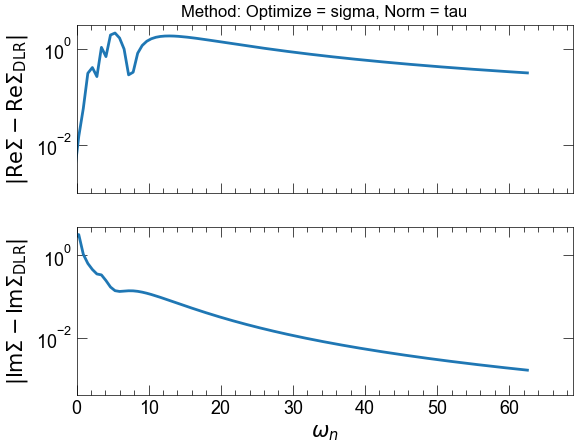

In [85]:
fig, ax = plt.subplots(2,1,sharex=True)
iw = np.array([complex(x) for x in G_iw.mesh])
ax[0].set_title('Method: Optimize = {}, Norm = {}'.format(method['optim'], method['norm']))
ax[0].semilogy(iw.imag, np.abs(Sigma_iw_fit.data[:,0,0].real-Sigma_iw.data[:,0,0].real))
ax[0].set_ylabel('$|\mathrm{Re}\Sigma-\mathrm{Re}\Sigma_{\mathrm{DLR}}|$')
ax[0].set_xlim(0,)
ax[1].semilogy(iw.imag, np.abs(Sigma_iw_fit.data[:,0,0].imag-Sigma_iw.data[:,0,0].imag))
ax[1].set_ylabel('$|\mathrm{Im}\Sigma-\mathrm{Im}\Sigma_{\mathrm{DLR}}|$')
ax[1].set_xlim(0,)
ax[1].set_xlabel(r'$\omega_{n}$')
plt.show()

# Dimer

In [ ]:
G0_tau = make_gf_from_fourier(G0_iw)
tau_i = np.array([x.real for x in G0_tau.mesh])
iw_i  = np.array([complex(x) for x in Sigma_iw_ref.mesh])
tol = 1e-4
G_tau_qmc= G_tau_ref.copy()
for block, _ in G_tau_qmc: G_tau_qmc[block].data[:] += np.random.normal(scale=tol, size=G_tau_qmc[block].data.shape)
d = dlr(lamb=30,eps=1e-9)

sig_xaa, sol = constrained_lstsq_dlr_from_tau(d, 
                                   tau_i, 
                                   beta,
                                   G_tau_qmc['up'].data,
                                   G0_tau['up'].data,
                                   sigma_moments['up'],
                                   method = {'optim': 'sigma', 
                                             'norm' : 'tau'},
                                   ftol=1e-9, 
                                   symmetrizer=None)
Sigma_iw_fit = Sigma_iw_ref.copy()
Sigma_iw_fit['up'].data[:] = d.eval_dlr_freq(sig_xaa, iw_i, beta) +sigma_moments['up'][0]

In [ ]:
iwn = np.array([complex(x) for x in Sigma_iw_ref.mesh])
fig, ax = plt.subplots(2,2,sharex=True,)
ax[0,0].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].real, label='exact')
ax[0,0].plot(iwn.imag, Sigma_iw_fit['up'].data[:,0,0].real, label='fit')
ax[0,0].set_ylabel('ReΣ')
ax[1,0].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].real-Sigma_iw_fit['up'].data[:,0,0].real))
ax[1,0].set_ylabel('ΔReΣ')
ax[1,0].set_xlabel('iωn')
ax[0,0].legend()
ax[0,1].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].imag, label='exact')
ax[0,1].plot(iwn.imag, Sigma_iw_fit['up'].data[:,0,0].imag, label='fit')
ax[0,1].set_ylabel('ImΣ')
ax[1,1].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].imag-Sigma_iw_fit['up'].data[:,0,0].imag))
ax[1,1].set_ylabel('ΔImΣ')
ax[1,1].set_xlabel('iωn')
ax[0,0].legend()
ax[0,0].set_xlim(0,60)
plt.subplots_adjust(hspace=0.25, wspace=0.5)
plt.show()